In [40]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langchain.pydantic_v1 import BaseModel,Field
from langchain_core.output_parsers import StrOutputParser
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langchain import hub
from langchain.schema import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain.vectorstores.chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os

In [41]:
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [42]:
class GradeScore(BaseModel):
    """Binary answer only on 'yes' or 'no"""
    binary_score : str = Field(
        description="Document are related to question, 'yes' or 'no'"
        )
    
class State(TypedDict):
    """
        store the given information in form of dictionary
    """
    question : str
    documents : list[str]
    generation : str
    web_search : str

In [43]:
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [44]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
        
doc = [WebBaseLoader(url).load() for url in urls]

doc_split = [item for split_doc in doc for item in split_doc]

text_split = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,chunk_overlap=50
)
splited_text = text_split.split_documents(doc_split)

vectorstore = Chroma(
    collection_name="jay_data",
    embedding_function=embedding
)
vectorstore.add_documents(splited_text)

retriever = vectorstore.as_retriever()

In [45]:
question = 'tell me about tajmahal'
document = retriever.get_relevant_documents(question)

In [46]:
prompt = hub.pull('rlm/rag-prompt')

rag_chain = prompt | llm | StrOutputParser()

rag_chain.invoke({'context':document,'question':question})

c:\Users\ADMIN\anaconda3\envs\jay\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


'I am sorry, but this document does not contain any information about the Taj Mahal.  I cannot answer your question.'

In [47]:
llm_structured_output = llm.with_structured_output(GradeScore)

system = """you are a gradescorer if document related to the question than give response only in 'yes" or 'no'"""

prompt = ChatPromptTemplate.from_messages(
    [
        ('system',system),
        ('human','here is the document: {document} and here is the question: {question}')
    ]
)

grad_chain = prompt | llm_structured_output
grad_chain.invoke({'document':document,'question':question})

GradeScore(binary_score='no')

In [48]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',system),
        ('human','here is the question:{question} that you have to rewrite')
    ]
)
rewrite_chain = rewrite_prompt | llm | StrOutputParser()
rewrite_chain.invoke({'question':question})

'What are some interesting facts about the Taj Mahal?'

In [49]:
def retriev(state):
    
    question = state['question']
    
    document = retriever.get_relevant_documents(question)
    
    return {'question':question,'documents':document}

In [50]:
def grad_document(state):
    
    question = state['question']
    document = state['documents']
    
    filterd_document = []
    
    web_search = 'no'
    for d in document:
        score = grad_chain.invoke({'document':d.page_content,'question':question})
        grad = score.binary_score
        if grad=='yes':
            filterd_document.append(d)
        else:
            web_search='yes'
            continue
    
    return {'question':question,'documents':document,'web_search':web_search}

In [51]:
def rewriter(state):
    
    question = state['question']
    document = state['documents']
    web_search = state['web_search']
    
    question = rewrite_chain.invoke({'question':question})
    
    return {'question':question,'documents':document,'web_search':web_search}

In [ ]:
def web_search_tool(state):
    question = state['question']
    document = state['documents']
    web_search = state['web_search']
    
    
    tavily = TavilySearchResults()
    
    web_output = tavily.invoke(question)
    
    print('question',question)
    print("web_output:", web_output)  # Debugging line
    
    web_searches = "\n".join([d['content'] for d in web_output])
    
    web_result = Document(page_content=web_searches)
    document.append(web_result)
    
    return {'question': question, 'documents': document, 'web_search': web_search}

In [53]:
def generator(state):
    
    question = state['question']
    document = state['documents']
    web_search = state['web_search']
    
    response = rag_chain.invoke({'question':question,'document':document})
    
    return {'question':question,'documents':document,'web_search':web_search,'generation':response}

In [54]:
def grad_condition(state):
    
    question = state['question']
    document = state['documents']
    web_search = state['web_search']
    
    if web_search=='yes':
        return 'rewriter'
    else:
        return 'generator'

In [55]:
workflow = StateGraph(State)
workflow.add_node('retriever',retriev)
workflow.add_node('grad_document',grad_document)
workflow.add_node('rewriter',rewriter)
workflow.add_node('web_search_tool',web_search_tool)
workflow.add_node('generator',generator)

workflow.add_edge(START,'retriever')
workflow.add_edge('retriever','grad_document')
workflow.add_conditional_edges('grad_document',
                               grad_condition,
                               {
                                   'rewriter':'rewriter',
                                   'generator':'generator'
                               })
workflow.add_edge('rewriter','web_search_tool')
workflow.add_edge('web_search_tool','generator')
workflow.add_edge('generator',END)
app = workflow.compile(checkpointer=MemorySaver())


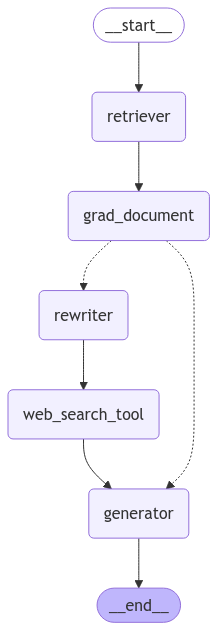

In [56]:
app

In [57]:
config = {'configurable':{'thread_id':'jay'}}

In [64]:
question = {'question':'tell me about Agent'}

In [65]:
response = app.invoke(question,config=config)

web_output: HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')


TypeError: string indices must be integers

In [ ]:
question = {'question':'tell me about Taj mahal'}